# Generative Adversarial Network For MNIST

In [2]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

### Configurations

In [3]:
device = 'cuda'
batch_size = 128
noise_dim = 60

lr = 2e-4
epochs = 20
beta_1 = 0.5
beta_2 = 0.99

### Load MNIST Dataset 

In [4]:
from torchvision import datasets
from torchvision import transforms as T

In [5]:
transformer = T.Compose([
                         T.RandomRotation((-20, 20)),
                         T.ToTensor()])

In [6]:
trainset = datasets.MNIST(root='MNIST/', download=True, train=True, transform=transformer)
len(trainset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



60000

5


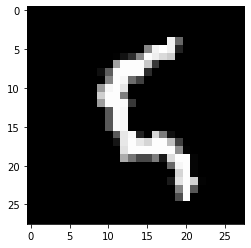

In [7]:
image, label = trainset[100]

plt.imshow(image[0, ...], cmap = 'gray')
print(label)

### Load Dataset Into Batches 

In [8]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [9]:
trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, 
                         num_workers=2, pin_memory=True)

In [10]:
print(len(trainloader))

469


In [11]:
for images, labels in trainloader:
  print(images.shape)
  break

torch.Size([128, 1, 28, 28])


In [12]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    ax = plt.axes()
    ax.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

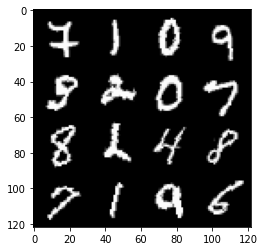

In [13]:
for images, labels in trainloader:
  show_tensor_images(images)
  break

### Create Discriminator Network 

In [14]:
!pip install torchsummary

In [15]:
from torchsummary import summary
import torch.nn as nn

In [17]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = self.building_block(1, 16, 3, 2)
    self.layer2 = self.building_block(16, 32, 5, 2)
    self.layer3 = self.building_block(32, 64, 5, 2)

    self.flatten = nn.Flatten()
    self.fc = nn.Linear(in_features=64, out_features=1)

  def building_block(self, in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

  def forward(self, x):
    o1 = self.layer1(x)

    o2 = self.layer2(o1)

    o3 = self.layer3(o2)

    return self.fc(self.flatten(o3))


In [18]:
my_discriminator = Discriminator().to(device)

summary(my_discriminator, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

### Create Generator Network 

In [23]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super().__init__()

    self.noise_dim = noise_dim
    self.layer1 = self.building_block(noise_dim, 256, 3, 2)
    self.layer2 = self.building_block(256, 128, 4, 1)
    self.layer3 = self.building_block(128, 64, 3, 2)
    self.layer4 = self.building_block(64, 1, 4, 2, True)


  def building_block(self, in_channels, out_channels, kernel_size, stride, final=False):
    if final:
      return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh() 
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
          nn.BatchNorm2d(out_channels),
          nn.ReLU()
      )

  def forward(self, random_vector):
    x = random_vector.view(-1, self.noise_dim, 1, 1)
    o1 = self.layer1(x)
    o2 = self.layer2(o1)
    o3 = self.layer3(o2)
    o4 = self.layer4(o3)
    return o4

In [26]:
my_generator = Generator(noise_dim).to(device)
summary(my_generator, input_size = (60,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         138,496
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 738,625
Trainable params: 738,625
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [27]:
def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [29]:
my_generator = my_generator.apply(weights_init)
my_discriminator = my_discriminator.apply(weights_init)

### Create Loss Function and Load Optimizer

In [30]:
def real_loss(discriminator_pred):
  loss = nn.BCEWithLogitsLoss()
  return loss(discriminator_pred, torch.ones_like(discriminator_pred))

In [31]:
def fake_loss(discriminator_pred):
  loss = nn.BCEWithLogitsLoss()
  return loss(discriminator_pred, torch.zeros_like(discriminator_pred))

In [34]:
discriminator_optimizer = torch.optim.Adam(params=my_discriminator.parameters() ,lr=lr, betas=(beta_1, beta_2))
generator_optimizer = torch.optim.Adam(params=my_generator.parameters() ,lr=lr, betas=(beta_1, beta_2))

### Training Loop 

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 1 | D_loss : 0.67 | G_loss : 0.72


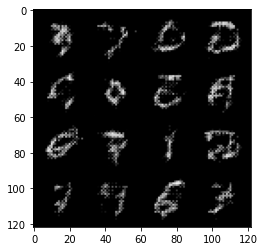

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 2 | D_loss : 0.61 | G_loss : 0.78


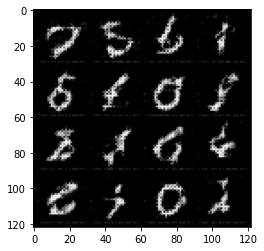

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 3 | D_loss : 0.58 | G_loss : 0.83


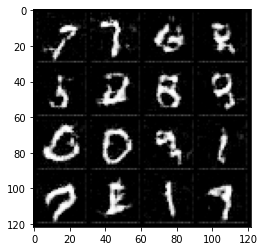

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 4 | D_loss : 0.57 | G_loss : 0.86


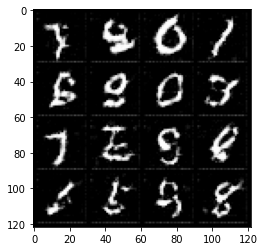

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 5 | D_loss : 0.56 | G_loss : 0.89


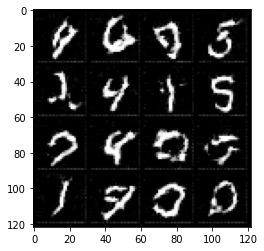

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 6 | D_loss : 0.57 | G_loss : 0.89


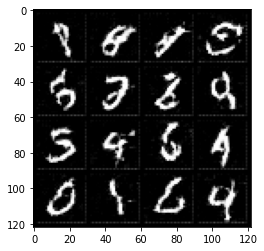

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 7 | D_loss : 0.59 | G_loss : 0.88


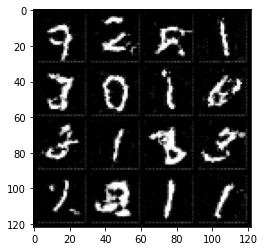

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 8 | D_loss : 0.60 | G_loss : 0.87


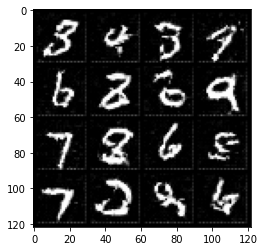

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 9 | D_loss : 0.61 | G_loss : 0.85


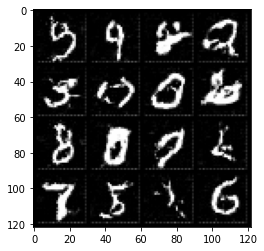

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 10 | D_loss : 0.62 | G_loss : 0.85


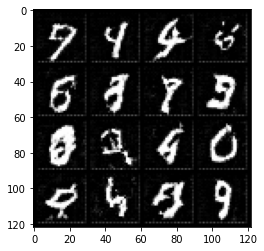

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 11 | D_loss : 0.62 | G_loss : 0.84


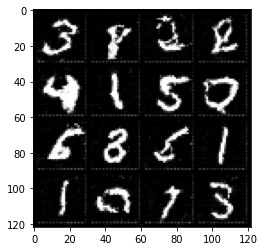

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 12 | D_loss : 0.62 | G_loss : 0.84


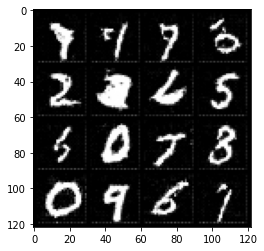

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 13 | D_loss : 0.63 | G_loss : 0.84


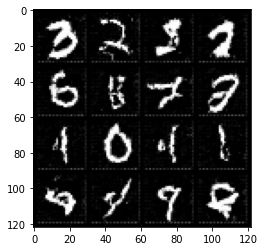

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 14 | D_loss : 0.63 | G_loss : 0.84


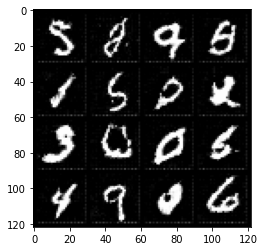

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 15 | D_loss : 0.63 | G_loss : 0.83


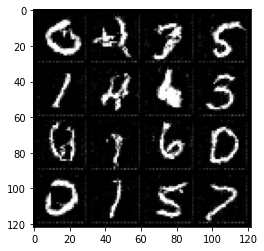

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 16 | D_loss : 0.63 | G_loss : 0.83


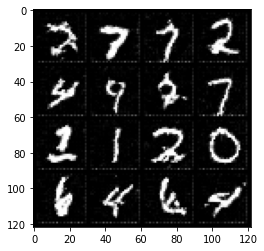

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 17 | D_loss : 0.63 | G_loss : 0.83


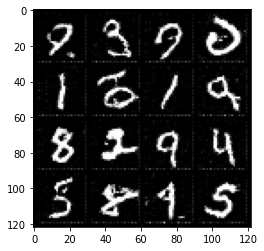

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 18 | D_loss : 0.63 | G_loss : 0.83


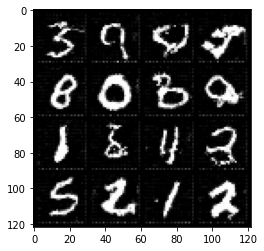

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 19 | D_loss : 0.63 | G_loss : 0.83


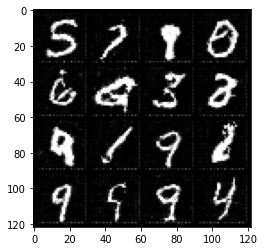

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch : 20 | D_loss : 0.63 | G_loss : 0.84


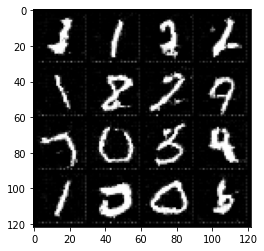

In [36]:
for epoch in range(epochs):

  total_D_loss = 0
  total_G_loss = 0

  for images, _ in tqdm(trainloader):
    
    real_images = images.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)
    fake_images = my_generator(noise)

    discriminator_optimizer.zero_grad()
    
    D_r_loss = real_loss(my_discriminator(real_images))
    D_f_loss = fake_loss(my_discriminator(fake_images))

    D_loss = (D_r_loss + D_f_loss) / 2

    total_D_loss += D_loss.item()
    D_loss.backward()

    discriminator_optimizer.step()

    generator_optimizer.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device = device)
    fake_images = my_generator(noise)

    G_loss = real_loss(my_discriminator(fake_images))

    total_G_loss += G_loss.item()
    G_loss.backward()

    generator_optimizer.step()

  avg_D_loss = total_D_loss / len(trainloader)
  avg_G_loss = total_G_loss / len(trainloader)

  print('epoch : {} | D_loss : {:.2f} | G_loss : {:.2f}'.format(epoch+1, avg_D_loss, avg_G_loss))

  show_tensor_images(fake_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


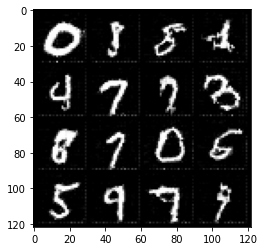

In [38]:
noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = my_generator(noise)

show_tensor_images(generated_image)